In [1]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

In [5]:
# A sample dataset to simulate a time series
# In a real-world scenario, you would load this from a CSV or database.
data = {
    'ds': pd.date_range(start='2024-01-01', end='2024-01-10'),
    'y': [100, 105, 110, 115, 120, 10, 130, 135, 140, 145] # Note the anomaly at index 5
}
df = pd.DataFrame(data)

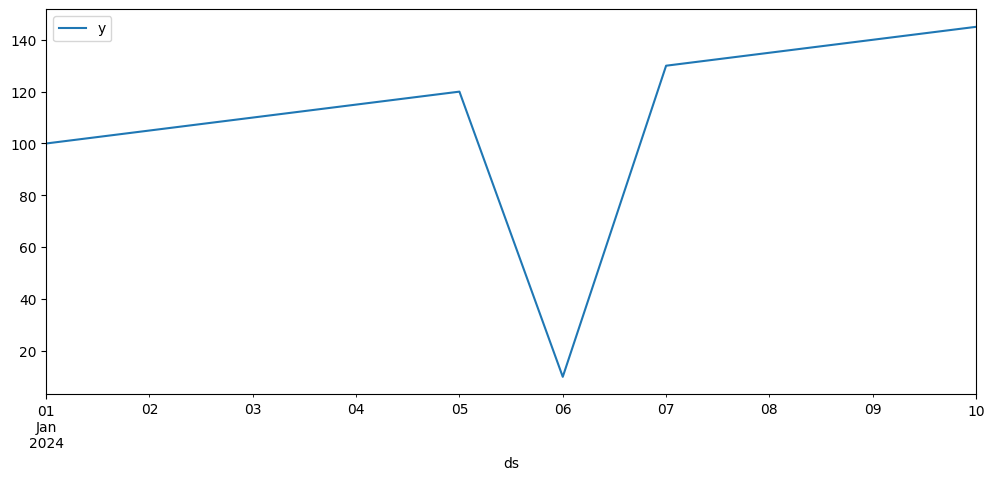

In [17]:
df.plot(x='ds', y='y', figsize=(12,5));

In [7]:

# 1. Model Training
# Initialize and fit the Prophet model
# We set seasonality_mode to 'additive' and tune changepoint_prior_scale for flexibility
m = Prophet(
    seasonality_mode='additive',
    changepoint_prior_scale=0.05
)
m.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpglcs_co3/ej29cocf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpglcs_co3/u9gyhjau.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=880', 'data', 'file=/tmp/tmpglcs_co3/ej29cocf.json', 'init=/tmp/tmpglcs_co3/u9gyhjau.json', 'output', 'file=/tmp/tmpglcs_co3/prophet_model0k54x9jz/prophet_model-20250922145906.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:59:06 - cmdstanpy - INFO - Chain [1] start processing
INFO

In [8]:
# 2. Making Forecasts on Historical Data
# Create a future dataframe that covers our existing data
future = m.make_future_dataframe(periods=0)
# Generate predictions
forecast = m.predict(future)

In [10]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-01-01,91.810955,49.464536,137.788231,91.810955,91.810955,0.0,0.0,0.0,0.0,0.0,0.0,91.810955
1,2024-01-02,96.115232,52.658050,136.699330,96.115232,96.115232,0.0,0.0,0.0,0.0,0.0,0.0,96.115232
2,2024-01-03,100.419508,58.063164,145.161181,100.419508,100.419508,0.0,0.0,0.0,0.0,0.0,0.0,100.419508
3,2024-01-04,104.723785,60.013405,149.177414,104.723785,104.723785,0.0,0.0,0.0,0.0,0.0,0.0,104.723785
4,2024-01-05,109.028062,65.770981,154.413469,109.028062,109.028062,0.0,0.0,0.0,0.0,0.0,0.0,109.028062
5,2024-01-06,113.332338,71.204520,156.187072,113.332338,113.332338,0.0,0.0,0.0,0.0,0.0,0.0,113.332338
6,2024-01-07,117.636615,73.309483,160.132473,117.636615,117.636615,0.0,0.0,0.0,0.0,0.0,0.0,117.636615
7,2024-01-08,121.940892,74.402552,161.509204,121.940892,121.940892,0.0,0.0,0.0,0.0,0.0,0.0,121.940892
8,2024-01-09,126.245168,83.709576,168.156513,126.245168,126.245168,0.0,0.0,0.0,0.0,0.0,0.0,126.245168
9,2024-01-10,130.549445,86.695613,170.764139,130.549445,130.549445,0.0,0.0,0.0,0.0,0.0,0.0,130.549445


In [11]:
# 3. Quantifying and Visualizing Anomalies
# Merge the actual data and the forecast
df_combined = pd.merge(df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
# Identify anomalies: where the actual value 'y' is outside the prediction interval
df_combined['is_anomaly'] = (df_combined['y'] < df_combined['yhat_lower']) | (df_combined['y'] > df_combined['yhat_upper'])
# Print the anomalies found
print("Detected Anomalies:")
print(df_combined[df_combined['is_anomaly']])

Detected Anomalies:
          ds   y        yhat  yhat_lower  yhat_upper  is_anomaly
5 2024-01-06  10  113.332338    71.20452  156.187072        True


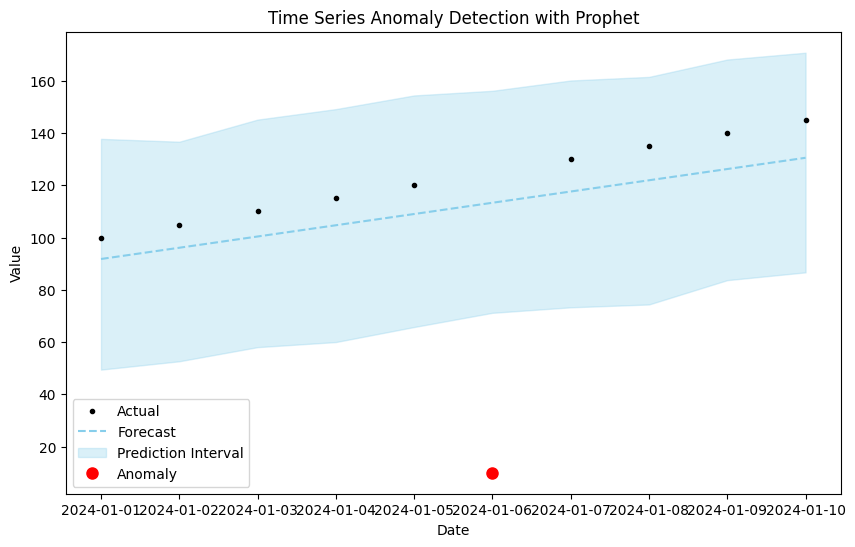

In [22]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_combined['ds'], df_combined['y'], 'k.', label='Actual')
ax.plot(df_combined['ds'], df_combined['yhat'], color='skyblue', linestyle='--', label='Forecast')
ax.fill_between(df_combined['ds'], df_combined['yhat_lower'], df_combined['yhat_upper'], color='skyblue', alpha=0.3, label='Prediction Interval')

# Highlight the anomalies
anomalies = df_combined[df_combined['is_anomaly']]
ax.plot(anomalies['ds'], anomalies['y'], 'ro', markersize=8, label='Anomaly')
ax.set_title("Time Series Anomaly Detection with Prophet")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend()
plt.show()